In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5-RadFeed']
basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [3]:
sn_list = []
idx_list = np.arange(400, 600)

for i in tqdm(idx_list):
    sn = read_snap(i, 0, lvl='lvl4', parttype=[2])
    sn_list.append(sn)

BoxSize = sn_list[0].BoxSize
center = np.array([BoxSize, BoxSize, BoxSize])/2.0

A Jupyter Widget

In [4]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [5]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [6]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [7]:
# get bar angle/pattern speed, and so on
fourier0 = read_fourier(0, lvl='lvl4')
out = main_bar_angle(fourier0)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


In [8]:
# construct orbits

tlist = []
wlist = []

for i,idx in enumerate(tqdm(idx_list)):
    sn = sn_list[i]
#     id_list = np.concatenate((sn.part2.id, sn.part3.id))
    id_list = sn.part2.id
    keys = np.argsort(id_list)
    
#     pos = np.concatenate((sn.part2.pos.value, sn.part3.pos.value))
    pos = sn.part2.pos.value
#     pos = pos[keys] - center
    pos = pos[keys]
    
#     vel = np.concatenate((sn.part2.vel.value, sn.part3.vel.value))
    vel = sn.part2.vel.value
    vel = vel[keys]
    
    w = np.hstack((pos, vel))
    
    wlist.append(w)    
    tlist.append(sn.Time.value)

wlist = np.array(wlist)
tlist = np.array(tlist)
# tlist -= tlist[5] # first few are to go back in time
    

A Jupyter Widget

In [9]:
# rotate wlist
def rotate_w(w, ang):

    # tmp = np.random.rand(50, 200, 6)
    # print(tmp[0][0])
    # ang = 2.*np.pi
    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    w = np.swapaxes(w, 0, 1)

    w[:3,:] = np.matmul(Rmat, w[:3,:])
    w[3:,:] = np.matmul(Rmat, w[3:,:])

    w = np.swapaxes(w, 0, 1)
    return w

# rotate by bar angle at each time step

bar_angle = np.mod(out['bar_angle'][idx_list], 2.*np.pi)

Rwlist = np.zeros(np.shape(wlist))

for i,idx in enumerate(tqdm(idx_list)):
    Rwlist[i] = rotate_w(wlist[i], -bar_angle[i])


A Jupyter Widget

In [10]:
def make_plot(w, rng=[[-15, 15], [-15, 15]], nres=256, vmin=1E0, vmax=10.**(2.5), ang=0.0):
    fig, ax = plt.subplots(1, 1)
    x = w[:,0]
    y = w[:,1]
    
    Rx = x * np.cos(-ang) - y * np.sin(-ang)
    Ry = x * np.sin(-ang) + y * np.cos(-ang)
    
    heatmap, _, _ = np.histogram2d(Rx, Ry, range=rng, bins=(nres, nres))
    
    extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
    ax.imshow(heatmap.T, extent=extent, origin='lower', 
                   norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    
    return fig, ax

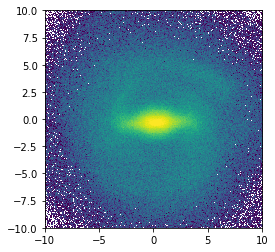

In [11]:
i=113
# fig, ax = make_plot(wlist[i], ang=angle[i])
fig, ax = make_plot(Rwlist[i], ang=0.0, rng=[[-10, 10], [-10, 10]])
plt.show()

In [12]:
def make_RV_plot(w, rng=[[0, 10], [0, 350]], nres=256, vmin=1E0, vmax=10.**(2.5)):
    fig, ax = plt.subplots(1, 1)
    x = w[:,0]
    y = w[:,1]
    
    vx = w[:,3]
    vy = w[:,4]
    
    R = np.sqrt(x*x + y*y)
    vtan = (x*vy - y*vx)/R
    
    heatmap, _, _ = np.histogram2d(R, vtan, range=rng, bins=(nres, nres))
    
    extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
    ax.imshow(heatmap.T, extent=extent, origin='lower', 
                   norm=mpl.colors.LogNorm(), vmin=vmin, vmax=vmax)
    
    ax.axis('auto')
    
    return fig, ax

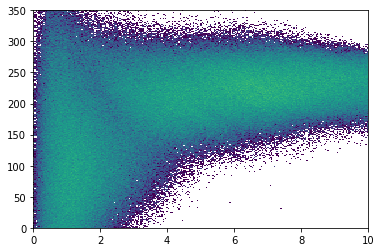

In [13]:
fig, ax = make_RV_plot(Rwlist[-1], nres=256)
plt.show()

In [14]:
def compute_angle_from_xaxis(pos):

    phi = np.arctan2(pos[:,1], pos[:,0])

    # assume pos x
    key = phi > np.pi
    phi_p = np.copy(phi)
    phi_p[key] = phi[key] - 2.*np.pi

    phi_n = np.copy(phi) + np.pi
    key = phi_n > np.pi
    phi_n[key] = phi_n[key] - 2.*np.pi

    phi_ = np.minimum(np.abs(phi_p), np.abs(phi_n))
#     phi_[np.abs(phi_)==np.abs(phi_p)] *= np.sign(phi_p[np.abs(phi_)==np.abs(phi_p)])
#     phi_[np.abs(phi_)==np.abs(phi_n)] *= np.sign(phi_n[np.abs(phi_)==np.abs(phi_n)])

    return phi_

def compute_trapping_metrics(orbit, tlist, Tanalyze):

    # first find the apoapses
    r = np.linalg.norm(orbit, axis=1)

    r_p1 = np.roll(r, 1)
    r_m1 = np.roll(r, -1)
    
    rcut = r[1:-1]
    r_p1_cut = r_p1[1:-1]
    r_m1_cut = r_m1[1:-1]

    apo_key = np.where(np.logical_and(rcut > r_p1_cut, rcut > r_m1_cut))[0]

    # now find the apoapse closest to the analysis time, the apoapse second closest (for omega r), and the list of 20 closest in time
    t_apo = tlist[1:-1][apo_key]

    key_sort = np.argsort(np.abs(t_apo-Tanalyze))
    if len(key_sort) < 20:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    key_closest = key_sort[0]
    key_second_closest = key_sort[1]

    key_20_closest = key_sort[:20]

    # warn if any of the 20 closest are at the edges
#     if np.any(apo_key[key_20_closest] == 0) or np.any(key_20_closest == len(tlist)-1):
#         print('apoapse at edge of array')
    
    # extract xy positions and do kmeans
    pos_xy = orbit[1:-1][apo_key[key_20_closest]][:,:2]

    kmeans = KMeans(n_clusters=2, random_state=0).fit(pos_xy)

    pos_xy_0 = pos_xy[kmeans.labels_==0]
    pos_xy_1 = pos_xy[kmeans.labels_==1]

    # now compute the four metrics from PWK19a
    phi_0 = compute_angle_from_xaxis(pos_xy_0)
    phi_1 = compute_angle_from_xaxis(pos_xy_1)
    
    # get max of delta phibar
    ave_delta_phibar = np.maximum(np.mean(phi_0), np.mean(phi_1))
    
    # average of std in R
    R_0 = np.linalg.norm(pos_xy_0, axis=1)
    R_1 = np.linalg.norm(pos_xy_1, axis=1)
    
    std_R0 = np.std(R_0, ddof=1)
    std_R1 = np.std(R_1, ddof=1)
    ave_stdR = (std_R0+std_R1)/2.0
    
    mean_R0 = np.mean(R_0)
    mean_R1 = np.mean(R_1)
    mean_R = (mean_R0 + mean_R1)/2.0
    
    std_phi0 = np.std(phi_0, ddof=1)
    std_phi1 = np.std(phi_1, ddof=1)
    ave_stdphi = (std_phi0+std_phi1)/2.0
    
    omega_r = np.abs(t_apo[key_closest] - t_apo[key_second_closest])
    omega_r = 1./omega_r
    
    return ave_delta_phibar, ave_stdR, mean_R, ave_stdphi, omega_r
    
orbit = Rwlist[:,0,:3]

ave_delta_phibar, ave_stdR, mean_R, ave_stdphi, omega_r = compute_trapping_metrics(orbit, tlist, 2.5)
print(ave_delta_phibar, ave_stdR, mean_R, ave_stdphi, omega_r)

0.4349714280435443 0.29560727059565406 2.0905873840724163 0.1970984552057457 33.57377049180328


In [15]:
ans_list = []
Tanalyze=2.5
n_proc=24


ans = Parallel(n_jobs=n_proc) (delayed(compute_trapping_metrics)(Rwlist[:,i,:3], tlist, Tanalyze) for i in tqdm(range(np.shape(Rwlist)[1])))

# for i in tqdm(range(np.shape(Rwlist)[1])):
#     orbit = Rwlist[:,i,:3]
#     ans = compute_trapping_metrics(orbit, tlist, Tanalyze)

# ans = np.array(ans)

A Jupyter Widget

In [16]:
ans = np.array(ans)
print(ans)

[[ 0.43497143  0.29560727  2.09058738  0.19709846 33.57377049]
 [        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 ...
 [ 0.60252911  0.31061423  2.12000113  0.36528176 24.97560976]
 [ 0.08046654  0.36903595  2.22933882  0.06864628 33.03225806]
 [        nan         nan         nan         nan         nan]]


In [26]:
def make_trapping_metric_plot(ans, rng=[[0, 10], [0, 350]], nres=256, vmin=1E0, vmax=10.**(2.5)):
    ave_delta_phibar = ans[:,0]
    ave_stdR = ans[:,1]
    mean_R = ans[:,2]
    ave_stdphi = ans[:,3]
    omega_r = ans[:,4]
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    
    rng = [[0, 1], [0, 0.5]]
    heatmap, _, _ = np.histogram2d(ave_delta_phibar, ave_stdR/mean_R, range=rng, bins=(nres, nres))
    extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
    ax[0].imshow(heatmap.T, extent=extent, origin='lower', 
                   norm=mpl.colors.LogNorm())
    ax[0].axvline(np.pi/8.0)
    ax[0].axhline(0.12)
    
    ax[0].set(xlabel='ave delta phibar', ylabel='ave sigmaR / ave R')
    
    rng = [[0, 1], [0, 1]]
    heatmap, _, _ = np.histogram2d(ave_delta_phibar, ave_stdphi, range=rng, bins=(nres, nres))
    extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
    ax[1].imshow(heatmap.T, extent=extent, origin='lower', 
                   norm=mpl.colors.LogNorm())

    ax[1].set(xlabel='ave delta phibar', ylabel='ave sigma phi')
    
    return fig, ax

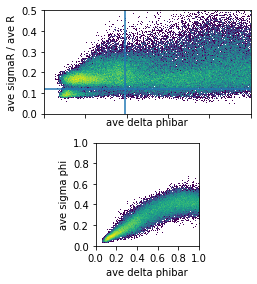

In [28]:
fig, ax = make_trapping_metric_plot(ans)
fig.tight_layout()
plt.show()

In [32]:
ave_delta_phibar = ans[:,0]
ave_stdR = ans[:,1]
mean_R = ans[:,2]
ave_stdphi = ans[:,3]
omega_r = ans[:,4]

key_phibar = ave_delta_phibar < np.pi/8.0
key_sigmar = ave_stdR/mean_R < 0.22
key_sigmaphi = ave_stdphi < np.pi/8.0

key_bar = np.logical_and(np.logical_and(key_phibar, key_sigmar), key_sigmaphi)

In [20]:
orbit_bar = Rwlist[:,key_bar,:3]

In [21]:
def plot_orbit(w):
    fig, ax = plt.subplots(1, 1)
    
    ax.plot(w[:,0], w[:,1])
    
    ax.axis('equal')
    return fig, ax

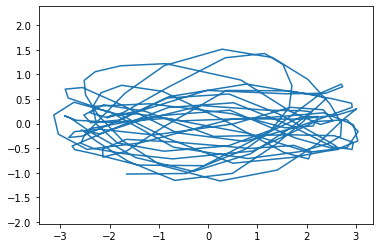

In [41]:
i = 17
fig, ax = plot_orbit(orbit_bar[:,i])
plt.show()

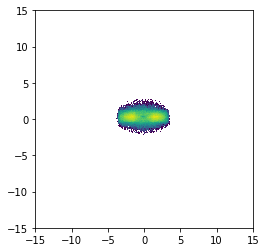

In [33]:
make_plot(Rwlist[100,key_bar])
plt.show()

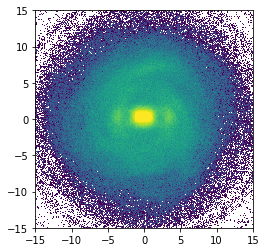

In [34]:
make_plot(Rwlist[100,np.logical_not(key_bar)])
plt.show()